# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# num_classes = 3
# num_train = 4
# num_features = 5

# seed = np.random.RandomState(0)
# W = seed.choice(np.arange(-1, 1, 0.1), num_features * num_classes).reshape(num_features, num_classes)
# X = np.column_stack([
#     seed.choice(np.arange(-10, 10, 1), num_train * (num_features-1)).reshape(num_train, num_features-1).T,
#     np.array([1] * num_train)
# ])
# y = seed.choice(np.arange(num_classes), num_train)

# print(W)
# print(X)
# print(y)

# scores = X.dot(W)
# scores -= np.max(scores, axis=1).reshape(-1, 1)
# print(scores)

# true_class_scores = np.choose(y, scores.T)
# true_class_idx = np.vstack([np.arange(y.shape[0]), y]).T
# print(true_class_scores)
# print(true_class_idx)
# dW_base = np.exp(scores) / np.sum(np.exp(scores), axis=1).reshape(-1, 1)
# print(np.round(dW_base, 3))
# print(dW_base)
# dW_base[true_class_idx[:, 0], true_class_idx[:, 1]] -= 1
# print(dW_base)

In [4]:
# print(X)
# print(np.sum(X, axis=0))

In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.413159
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** So, we have 10 classes that means that a (weighted to class sizes) random guess returns the true class with 0.1 probability on i-th iteration. 


In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.005958 analytic: 3.005958, relative error: 1.671430e-08
numerical: 1.576544 analytic: 1.576544, relative error: 2.533227e-08
numerical: 1.334858 analytic: 1.334858, relative error: 7.499904e-09
numerical: -1.974628 analytic: -1.974627, relative error: 1.073943e-08
numerical: -1.006655 analytic: -1.006655, relative error: 6.646002e-09
numerical: 3.032859 analytic: 3.032859, relative error: 5.730056e-09
numerical: 0.113889 analytic: 0.113889, relative error: 5.080727e-08
numerical: -0.748669 analytic: -0.748669, relative error: 6.417770e-08
numerical: 3.838996 analytic: 3.838996, relative error: 1.045930e-08
numerical: -1.811041 analytic: -1.811041, relative error: 8.513811e-09
numerical: -2.150687 analytic: -2.150687, relative error: 1.094808e-08
numerical: 0.091318 analytic: 0.091318, relative error: 8.107735e-07
numerical: -0.054024 analytic: -0.054024, relative error: 1.097491e-06
numerical: -0.451107 analytic: -0.451107, relative error: 4.056654e-08
numerical: 3.102516 

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.413159e+00 computed in 0.842749s
vectorized loss: 2.413159e+00 computed in 0.023396s
Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6, 5e-6, 1e-7, 5e-7, 1e-8]
regularization_strengths = [1e4, 2.5e4, 5e4, 7.5e4, 1e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

sm = Softmax()
sms = {}

for lr in learning_rates:
    for C in regularization_strengths:
        # train
        sm.train(X_train, y_train, learning_rate=lr, reg=C)
        # predict
        y_train_pred = sm.predict(X_train)
        y_val_pred = sm.predict(X_val)
        # scoring
        train_score = np.mean(y_train == y_train_pred)
        val_score = np.mean(y_val == y_val_pred)
        # store results
        results[(lr, C)] = (train_score, val_score)
        sms[(lr, C)] = sm

sorted_results = sorted(results.items(), key=lambda x: (x[1], x[1])) # by val score
best_params = sorted_results[-1][0]
best_val = sorted_results[-1][1][1]
best_softmax = sms[best_params]
print(best_softmax.lr, best_softmax.C)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1e-08 100000.0
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.418204 val accuracy: 0.403000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.418327 val accuracy: 0.405000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.418122 val accuracy: 0.407000
lr 1.000000e-08 reg 7.500000e+04 train accuracy: 0.418510 val accuracy: 0.406000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.418857 val accuracy: 0.406000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.400551 val accuracy: 0.391000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.403735 val accuracy: 0.396000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.407245 val accuracy: 0.393000
lr 1.000000e-07 reg 7.500000e+04 train accuracy: 0.408633 val accuracy: 0.397000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.409735 val accuracy: 0.397000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.411367 val accuracy: 0.404000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.415245 val accuracy: 0.400000
lr 5.000000e-

In [9]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.387000


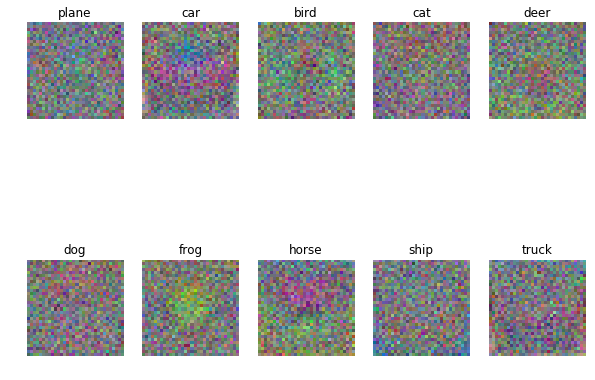

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])